In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from scipy.stats import *
from scipy.signal import *
import datetime
from scipy import *
from shapely.geometry import Polygon
import geopandas as gpd
import xarray as xr
from windrose import WindroseAxes
import os
import glob

#  Location Parameter 

Wind Input File Data

In [2]:
# List of file names
file_names = glob.glob('F:/TUDELFT/Thesis/Thesis_CODE/Windspeed/*.nc')

# Load all files as a list of datasets
datasets = [xr.open_dataset(file) for file in file_names]

# Combine the datasets into one dataset
combined = xr.concat(datasets, dim='time')

# List of variables to convert to DataFrame
variables = ['u100', 'v100']

# Convert each variable to DataFrame and store in a dictionary
dataframes = {var: combined[var].to_dataframe().reset_index() for var in variables}

# Extract individual DataFrames
df_wind_u100 = dataframes['u100']
df_wind_v100 = dataframes['v100']

# Calculate the total wind speed
df_wind_u100.set_index('time', inplace=True)
df_wind_v100.set_index('time', inplace=True)

total_windspeed = np.hypot(df_wind_u100['u100'], df_wind_v100['v100'])

# Create a new DataFrame with the time index and the calculated windspeed
df_wind = pd.DataFrame({
    'time': df_wind_u100.index,
    'windspeed': total_windspeed
})

df_wind_total = np.hypot(df_wind_u100['u100'], df_wind_v100['v100'])
df_wind_total = pd.DataFrame({'windspeed': df_wind_total})

df_wind.head()
single_speed = df_wind.iloc[0]['windspeed']

In [3]:
# Calculate wind speed at the hub
zh = 138
z_0 = 0.0002
z_ref = 100

df_u100_hub = df_wind_u100.copy()
df_v100_hub = df_wind_v100.copy()
df_wind_hub = df_wind_total.copy()
df_u100_hub['u100'] = df_wind_u100['u100'] * np.log(zh / z_0) / np.log(z_ref / z_0)
df_v100_hub['v100'] = df_wind_v100['v100'] * np.log(zh / z_0) / np.log(z_ref / z_0)
df_wind_hub['windspeed'] = df_wind_total['windspeed'] * np.log(zh / z_0) / np.log(z_ref / z_0)


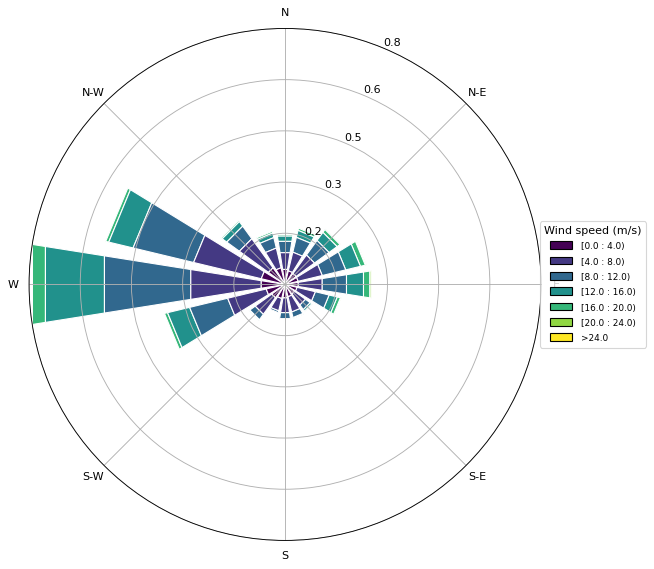

In [4]:
# Calculate wind direction transversed to hubheight 
wind_direction = np.arctan2(df_v100_hub['v100'], df_u100_hub['u100']) * (180 / np.pi)
wind_direction = (wind_direction + 360) % 360  # Convert to 0-360 degrees

# Combine wind speed and direction into one DataFrame
df_wind_trans = pd.DataFrame({
    'windspeed': df_wind_hub['windspeed'],
    'direction': wind_direction
})

# Define custom bins and labels for wind speeds
bins = [0, 4, 8, 12, 16, 20, 24]
labels = ['0-4', '4-8', '8-12','12-15']

# Create a wind rose plot
ax = WindroseAxes.from_ax()

# Plot the wind rose with specific parameters
ax.bar(df_wind_trans['direction'], df_wind_trans['windspeed'], bins=bins, normed=True, opening=0.8, edgecolor='white')

# Adjust legend and add units
legend = ax.set_legend(title="Wind speed (m/s)", loc='center left', bbox_to_anchor=(1, 0.5), labels=labels)

plt.show()

# Layout 

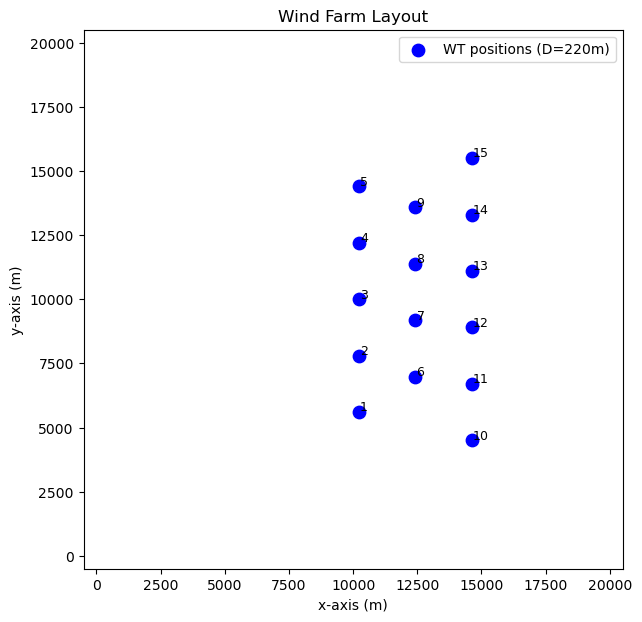

Total turbines placed: 15


In [5]:
# Wind farm area
farm_length = 20000  # x-axis (m)
farm_width = 20000   # y-axis (m)

# Rotor diameter
d0 = 220  # [m]
min_spacing_x = 10 * d0
min_spacing_y = 10 * d0

# Desired layout: 
layout_cols = [5, 4, 6]
n_turbines = sum(layout_cols)

# Generate turbine positions in zigzag pattern
turbines = []
row_spacing = min_spacing_y
col_spacing = min_spacing_x

start_x = d0 + 10000
start_y = farm_width / 2 - (len(layout_cols) - 1) * row_spacing / 2

for i, n_rows in enumerate(layout_cols):
    x = start_x + i * (col_spacing)
    total_height = (n_rows - 1) * row_spacing
    y_start = farm_width / 2 - total_height / 2
    for j in range(n_rows):
        y = y_start + j * row_spacing
        if i % 2 == 1:
            y += row_spacing / 8
        turbines.append((x, y))

turbines = np.array(turbines)

# Plot the layout
plt.figure(figsize=(7, 7))
plt.scatter(turbines[:, 0], turbines[:, 1], c='blue', label="WT positions (D=220m)", s=80)
for idx, (x, y) in enumerate(turbines):
    plt.text(x + 50, y + 50, str(idx + 1), fontsize=9, color='black')
plt.xlim(-500, farm_length + 500)
plt.ylim(-500, farm_width + 500)
plt.xlabel("x-axis (m)")
plt.ylabel("y-axis (m)")
plt.title("Wind Farm Layout")
plt.legend()
plt.gca().set_aspect('equal')
plt.show()

print(f"Total turbines placed: {len(turbines)}")


In [6]:
from scipy.spatial import distance_matrix
dist_matrix = distance_matrix(turbines, turbines)
np.fill_diagonal(dist_matrix, np.inf)  # Ignore self-distance
min_distances = np.min(dist_matrix, axis=1)

df_closest = pd.DataFrame({
    'Turbine #': np.arange(1, n_turbines + 1),
    'Closest Distance (m)': np.round(min_distances, 2)
})
df_closest

,Turbine #,Closest Distance (m)
0,1,2200.0
1,2,2200.0
2,3,2200.0
3,4,2200.0
4,5,2200.0
5,6,2200.0
6,7,2200.0
7,8,2200.0
8,9,2200.0
9,10,2200.0


# Power Calculation

Available Power with Wake

In [7]:
# Rated wind speed
rated_wind_speed = 10.5  # m/s
max_wind_hub = df_wind_hub['windspeed'].max

print(max_wind_hub)

<bound method NDFrame._add_numeric_operations.<locals>.max of time
0     11.500008
0     11.242368
0     10.297373
0     11.707512
0     11.589829
        ...    
25     7.209535
25     6.307199
25     7.073669
25     7.529493
25     7.312706
Name: windspeed, Length: 35556768, dtype: float64>


In [8]:
# Parameters
n_turbines = 15
d0 = 220
R = d0 / 2
rated_power = 12  # MW
Cp = 0.45
rho = 1.225
CT = 8/9
k_star = 0.04
b = 0.5 * (1 + np.sqrt(1 - CT)) / np.sqrt(1 - CT)
epsilon = 0.25 * np.sqrt(b)

# Rotor Grid
Ny, Nz = 15, 15
y_vals = np.linspace(-R, R, Ny)
z_vals = np.linspace(zh - R, zh + R, Nz)
dy = y_vals[1] - y_vals[0]
dz = z_vals[1] - z_vals[0]
Y, Z = np.meshgrid(y_vals, z_vals)
mask = np.pi * (Y**2 + (Z - zh)**2) <= np.pi * R**2

# Wake model functions
def sigma(x):
    return d0 * (k_star * (x / d0) + epsilon)

def C_deficit(x):
    sig = sigma(x)
    val = 1 - CT / (8 * (sig / d0)**2)
    return 1 - np.sqrt(val)

# Calculate power at 10.5 m/s wind
actual_powers = []
for i in range(n_turbines):
    xi, yi = turbines[i]
    U_rotor = rated_wind_speed * np.ones_like(Y)

    for j in range(n_turbines):
        if j == i:
            continue
        xj, yj = turbines[j]
        dx = xi - xj
        dy_rel = yi - yj
        if dx > 0:
            r_squared = (Y - dy_rel)**2 + (Z - zh)**2
            sig = sigma(dx)
            Cx = C_deficit(dx)
            U_wake = rated_wind_speed * (1 - Cx * np.exp(-0.5 * r_squared / (sig * d0)**2))
            U_rotor = np.minimum(U_rotor, U_wake)

    U_effective = U_rotor[mask]
    P_available = 0.5 * rho * np.sum(U_effective**3) * dy * dz
    P_actual = float(Cp * P_available / 1e6)
    P_actual = min(P_actual, rated_power)
    actual_powers.append(P_actual)

# Create result table
df_result = pd.DataFrame(turbines, columns=["X (m)", "Y (m)"])
df_result["Power (MW)"] = actual_powers

print(df_result)

      X (m)    Y (m)  Power (MW)
0   10220.0   5600.0   11.739837
1   10220.0   7800.0   11.739837
2   10220.0  10000.0   11.739837
3   10220.0  12200.0   11.739837
4   10220.0  14400.0   11.739837
5   12420.0   6975.0    8.469353
6   12420.0   9175.0    8.469353
7   12420.0  11375.0    8.469353
8   12420.0  13575.0    8.469353
9   14620.0   4500.0    8.475328
10  14620.0   6700.0    8.468689
11  14620.0   8900.0    8.468689
12  14620.0  11100.0    8.468689
13  14620.0  13300.0    8.468689
14  14620.0  15500.0    8.472674


Wind Generation Distribution

Weibull parameters: shape=1.945, loc=0.000, scale=8.967


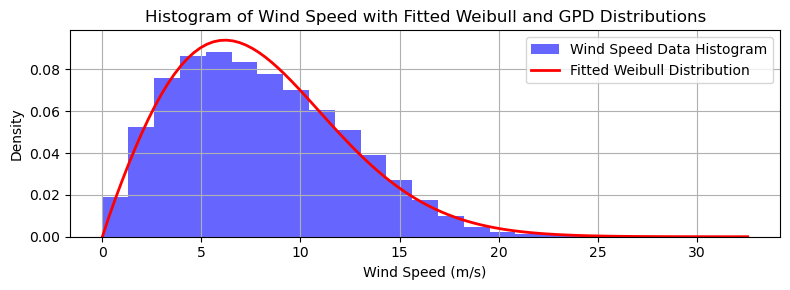

In [9]:
from scipy.stats import weibull_min, genpareto

# Assuming df_wind_total is already defined and contains the windspeed data
# Convert the index to datetime if not already
df_wind_total.index = pd.to_datetime(df_wind_total.index)

# Extract the windspeed data
windspeed_data = df_wind_hub['windspeed']
windspeed_data_clean = windspeed_data[np.isfinite(windspeed_data)]

# Fit a Weibull distribution to the data
params_weibull = weibull_min.fit(windspeed_data_clean, floc=0)
shape_weibull, loc_weibull, scale_weibull = params_weibull
print(f'Weibull parameters: shape={shape_weibull:.3f}, loc={loc_weibull:.3f}, scale={scale_weibull:.3f}')

# Generate x values for the Weibull PDF plot
x = np.linspace(windspeed_data.min(), windspeed_data.max(), 100)

# Calculate the PDF of the Weibull distribution
pdf_weibull = weibull_min.pdf(x, shape_weibull, loc_weibull, scale_weibull)

# Plot the histogram of the wind speed data and the fitted distributions
plt.figure(figsize=(8, 3))
plt.hist(windspeed_data, bins=25, density=True, alpha=0.6, color='b', label='Wind Speed Data Histogram')
plt.plot(x, pdf_weibull, 'r-', lw=2, label='Fitted Weibull Distribution')
# plt.plot(x, pdf_gpd, 'g-', lw=2, label='Fitted GPD Distribution')

# Add plot details
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Density')
plt.title('Histogram of Wind Speed with Fitted Weibull and GPD Distributions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Power curves 

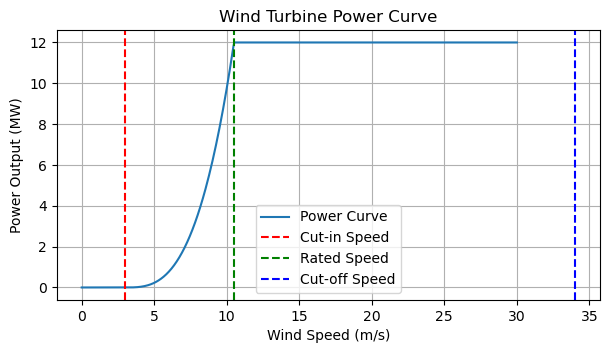

In [10]:
cutin_speed = 3 #m/s
r_speed = 10.5 #m/s
cutoff_speed = 34 #m/s
rated_power = 12 #MW 

wind_speed = np.linspace(0, 30, 500)
power_output_greedy = np.zeros_like(wind_speed)

for i, v in enumerate(wind_speed):
    if v < cutin_speed:
        power_output_greedy[i] = 0
    elif cutin_speed <= v < r_speed:
        power_output_greedy[i] = rated_power * ((v - cutin_speed) / (r_speed - cutin_speed)) ** 3
    elif r_speed <= v <= cutoff_speed:
        power_output_greedy[i] = rated_power
    else:
        power_output_greedy[i] = 0
        
plt.figure(figsize=(7, 3.5))
plt.plot(wind_speed, power_output_greedy, label='Power Curve')
plt.axvline(cutin_speed, color='r', linestyle='--', label='Cut-in Speed')
plt.axvline(r_speed, color='g', linestyle='--', label='Rated Speed')
plt.axvline(cutoff_speed, color='b', linestyle='--', label='Cut-off Speed')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power Output (MW)')
plt.title('Wind Turbine Power Curve')
plt.legend()
plt.grid(True)
plt.savefig('./power_curve.png')
plt.show()

Annual Energy Production

In [11]:
actual_power_per_turbine = [actual_powers]
# Define Weibull distribution
T = 365 * 24
U = np.linspace(cutin_speed, cutoff_speed, 1000)
f_U = weibull_min.pdf(U, shape_weibull, scale=scale_weibull)

# AEP (greedy case using power curve)
P_U = np.interp(U, wind_speed, power_output_greedy)
P_greedy = P_U * f_U * n_turbines
AEP_greedy = T * np.trapz(P_greedy, U)

# AEP (wake case using constant actual_power_per_turbine at rated wind)
prob_range = np.trapz(f_U, U)
avg_actual_power = np.mean(actual_power_per_turbine)
AEP_wake = T * avg_actual_power * prob_range * n_turbines

# Print results
print(f"AEP the whole farm without wake: {AEP_greedy:.2f} MWh/year")
print(f"AEP the whole farm with wake: {AEP_wake:.2f} MWh/year")

AEP the whole farm without wake: 635198.00 MWh/year
AEP the whole farm with wake: 1115410.32 MWh/year


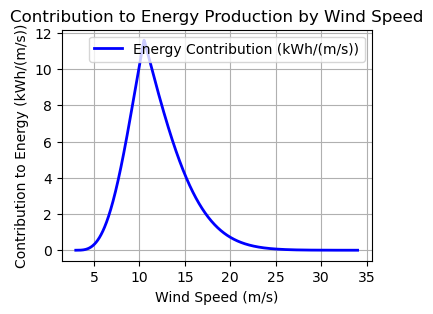

In [12]:
# Plot the energy contribution
plt.figure(figsize=(4, 3))
plt.plot(U, P_greedy, 'b-', lw=2, label='Energy Contribution (kWh/(m/s))')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Contribution to Energy (kWh/(m/s))')
plt.title('Contribution to Energy Production by Wind Speed')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
#Capacity Factor 
CF_w = (AEP_wake / 15) / (T * avg_actual_power) 
CF_nw = (AEP_greedy / 15) / (T * rated_power)

#Energy Yield 
Energy_yield_w = 8760 * np.sum(actual_powers) * CF_w
Energy_yield = 8760 * n_turbines * rated_power * CF_nw

print(f"Capacity Factor without wake: {CF_nw:.2f}")
print(f"Capacity Factor with wake: {CF_nw:.2f}")
print(f"Energy Yield of Wind Farm with wake effects: {Energy_yield_w:.2f} MWh")
print(f"Energy Yield of Wind Farm without wake effects: {Energy_yield:.2f} MWh")


Capacity Factor without wake: 0.40
Capacity Factor with wake: 0.40
Energy Yield of Wind Farm with wake effects: 1115410.32 MWh
Energy Yield of Wind Farm without wake effects: 635198.00 MWh


# Cable Sizing (Length and Area)

In [14]:
# Define sequences of interest
paths = [
    [5, 9, 14, 15],
    [4, 8, 13],
    [3, 7, 12],
    [10, 11, 6, 2, 1]
]

# Adjust to 0-based indices for Python
paths = [[i - 1 for i in seq] for seq in paths]

# Extract x and y coordinates
x_coords = turbines[:, 0]
y_coords = turbines[:, 1]

# Calculate pairwise x and y differences along each path
results = []
for path in paths:
    for i in range(len(path) - 1):
        from_idx = path[i]
        to_idx = path[i + 1]
        dx = x_coords[to_idx] - x_coords[from_idx]
        dy = y_coords[to_idx] - y_coords[from_idx]
        results.append({
            'From': from_idx + 1,
            'To': to_idx + 1,
            'Δx (m)': round(dx, 2),
            'Δy (m)': round(dy, 2)
        })

df_deltas = pd.DataFrame(results)
df_deltas


,From,To,Δx (m),Δy (m)
0,5,9,2200.0,-825.0
1,9,14,2200.0,-275.0
2,14,15,0.0,2200.0
3,4,8,2200.0,-825.0
4,8,13,2200.0,-275.0
5,3,7,2200.0,-825.0
6,7,12,2200.0,-275.0
7,10,11,0.0,2200.0
8,11,6,-2200.0,275.0
9,6,2,-2200.0,825.0


In [15]:
from scipy.integrate import quad

# Average water depth
f = 80  # meters

# Functions from Slender Structure Lecture 
def dz_d_dir(f, l):
    return lambda s: (4 * f / l**2) * (l - 2 * s) *1.2

def arc_length_integrand(dz_d):
    return lambda s: np.sqrt(1 + dz_d(s)**2)

# Calculate cable lengths
results = []
for path in paths:
    for i in range(len(path) - 1):
        from_idx = path[i]
        to_idx = path[i + 1]
        dx = x_coords[to_idx] - x_coords[from_idx]
        dy = y_coords[to_idx] - y_coords[from_idx]

        # Determine direction and calculate arc length accordingly
        if abs(dx) > 0:
            l = abs(dx)
            dz = dz_d_dir(f, l)
            integrand = arc_length_integrand(dz)
            L, _ = quad(integrand, 0, l)
        elif abs(dy) > 0:
            l = abs(dy)
            dz = dz_d_dir(f, l)
            integrand = arc_length_integrand(dz)
            L, _ = quad(integrand, 0, l)
        else:
            L = 0  # No length between identical points

        results.append({
            'From': from_idx + 1,
            'To': to_idx + 1,
            'Cable Length L (m)': round(L, 2)
        })

df_cable_lengths = pd.DataFrame(results)
df_cable_lengths


,From,To,Cable Length L (m)
0,5,9,2211.12
1,9,14,2211.12
2,14,15,2211.12
3,4,8,2211.12
4,8,13,2211.12
5,3,7,2211.12
6,7,12,2211.12
7,10,11,2211.12
8,11,6,2211.12
9,6,2,2211.12


In [16]:
# Constants
rated_voltage = 66 * 10**3  # 66 kV
resistance = 0.21  # Ohms per km because it can held up to 411 A 
total_length_km = np.sum(df_cable_lengths)  # Total cable length in km
reactive_power = 3.16 * 10**6  # Reactive power in VAR (constant for this example)

current_flow = []
for P_actual in actual_powers: 
    P = P_actual * 10**6 
    apparent_power = np.sqrt(P**2 + reactive_power**2) #VA 
    power_factor = np.arccos(P / apparent_power) if apparent_power != 0 else 0
    I = apparent_power / (np.sqrt(3) * rated_voltage * power_factor) if power_factor != 0 else 0
    current_flow.append(I)

df_current = pd.DataFrame({
    'Turbine': np.arange(1, len(actual_powers)+1),
    'Power Output (MW)': actual_powers,
    'Current (A)': np.round(current_flow, 2),
})
print(df_current)

    Turbine  Power Output (MW)  Current (A)
0         1          11.739837       404.48
1         2          11.739837       404.48
2         3          11.739837       404.48
3         4          11.739837       404.48
4         5          11.739837       404.48
5         6           8.469353       221.43
6         7           8.469353       221.43
7         8           8.469353       221.43
8         9           8.469353       221.43
9        10           8.475328       221.71
10       11           8.468689       221.40
11       12           8.468689       221.40
12       13           8.468689       221.40
13       14           8.468689       221.40
14       15           8.472674       221.59


In [17]:
rated_voltage = 66 * 10**3  # 66 kV
resistance = 0.21  # Ohms/km because it can held up to 411 A 
total_length_km = np.sum(df_cable_lengths)  # Total cable length in km
reactive_power = 3.16 * 10**6  # Reactive power in VAR (constant for this example)

power_loss = []
for _ in actual_powers:
    loss = (I**2 * resistance) / 10e3  # in kW
    power_loss.append(loss)

df_loss = pd.DataFrame({
    'Turbine': np.arange(1, len(actual_powers)+1),
    'Power Output (MW)': actual_powers,
    'Power Loss (kW) per km': np.round(power_loss, 4),
})

df_loss

,Turbine,Power Output (MW),Power Loss (kW) per km
0,1,11.739837,1.0311
1,2,11.739837,1.0311
2,3,11.739837,1.0311
3,4,11.739837,1.0311
4,5,11.739837,1.0311
5,6,8.469353,1.0311
6,7,8.469353,1.0311
7,8,8.469353,1.0311
8,9,8.469353,1.0311
9,10,8.475328,1.0311
